In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
from operators import *

Notation: $V \rightarrow \sigma$, $U \rightarrow \tau$, $\omega=e^{2\pi i/3}$
\begin{equation}
\hat H = \sum_j [(J-imG_j^*) \hat\sigma^\dagger_{j-1,j} \hat\sigma_{j,j+1}+h.c.]+h \sum_{n=-\infty}^{+\infty}\delta(t-n)\frac{2\pi i}{3\sqrt{3}}\sum_j (\hat \tau_{j,j+1}-h.c.)
\end{equation}
Exact kick for $h=1$

Other terms
\begin{equation}
\hat H' = \hat H+h_z \sum_j (e^{i\phi_z}\hat \sigma_{j,j+1}+h.c.)+h_x \sum_j (e^{i\phi_x}\hat \tau_{j,j+1}+h.c.)
\end{equation}

In [2]:
h=0.99
m=1.0
J=1.0
hz=0.1
phiz=0.0
hx=0.0
phix=0.0
n_dis=100
#index=1
f=0.9

In [3]:
omega=np.exp(1j*2*np.pi/3)
sigma = np.array([[1,0,0],[0,omega,0],[0,0,omega**2]])
tau = np.array([[0,0,1],[1,0,0],[0,1,0]])

In [4]:
kick = la.expm(h*2*np.pi/(3*np.sqrt(3))*(tau-np.transpose(tau)))

In [5]:
def build_H(J,m,hz,hx,L):
    dim = 3**L
    H = np.zeros((dim, dim), dtype=float)
    g = np.random.choice([1,omega, omega**2], size=L)
    for site in range(L):
        H=H+2*np.real((J-1j*g[site]*m)*\
                      two_site_op(np.conj(sigma), sigma, site, site+1, L))
        H=H+hx*2*np.real(np.exp(1j*phix)*one_site_op(tau, site, L))
        H=H+hz*2*np.real(np.exp(1j*phiz)*one_site_op(sigma, site, L))
    return H

We study the quantity
\begin{equation}
Z(nT)=\overline{\langle \omega^n \sigma(0)_{j,j+1}\sigma^\dagger_{j,j+1}(nT)\rangle}
\end{equation}
averaged over $j$, disorder $\{G_j\}$ (it is constantly 1 for $h=1$, $h_x=0$).

### Example

In [8]:
sizes = [2,3,4,5]
#time_set = np.power(2, np.arange(40))
#time_set=np.arange(60000, step=19)
time_set = (np.power(1.2, np.arange(100))).astype(int)
ReZ=np.zeros((len(sizes), len(time_set)), dtype=float)
ImZ=np.zeros((len(sizes), len(time_set)), dtype=float)
varReZ=np.zeros((len(sizes), len(time_set)), dtype=float)
varImZ=np.zeros((len(sizes), len(time_set)), dtype=float)

for countL, L in enumerate(sizes):
    filename='Z3/Z3_L{}_f{}_h{}_m{}_J{}_hz{}_phiz{}_hx{}_phix{}_ndis{}.txt'.format(L,f,h,m,J,hz,phiz,hx,phix,n_dis)
    initial_state=np.zeros(3**L)
    flips = L-int(L*f)
    index=np.sum(np.power(3, np.random.randint(L, size=flips)))
    initial_state[index]=1
    print("Initial state (local magnetization) ",[expect_val(one_site_op(sigma, i, L), initial_state) for i in range(L)])

    K = kick
    for _ in range(L-1):
        K = np.kron(K, kick)

    
    for counter in range(n_dis):
        start = time.time()

        H = build_H(J,m,hz,hx,L)
        U_F = np.dot(la.expm(-1j*H),K)
        eigval, eigvec = np.linalg.eig(U_F)
        spectrum = np.angle(eigval)

        final_state = evolve(time_set, initial_state, eigvec, eigval)
        for i in range(L):
            val=expect_val(one_site_op(sigma, i, L), initial_state)*\
                     expect_val(one_site_op(np.conj(sigma), i, L),final_state)\
                     *(omega)**(time_set%3)
            ReZ[countL]+=np.real(val)
            varReZ[countL]+=np.real(val)**2 
            ImZ[countL]+=np.imag(val)
            varImZ[countL]+=np.imag(val)**2 
        elapsed = time.time()-start
        #print('size', L, '\tdisorder realization', counter,'\ttime elapsed', elapsed)
        
    ReZ[countL]=ReZ[countL]/(L*n_dis)
    varReZ[countL]=(varReZ[countL]/(L*n_dis)-ReZ[countL]**2)/(L*n_dis-1)
    ImZ[countL]=ImZ[countL]/(L*n_dis)
    varImZ[countL]=(varImZ[countL]/(L*n_dis)-ImZ[countL]**2)/(L*n_dis-1)
#     with open(filename, 'wb') as outfile:
#         outfile.write(('# '+filename+'\n').encode('utf-8'))
#         np.savetxt(outfile, np.stack((time_set, ReZ[countL], ImZ[countL], varReZ[countL], varImZ[countL]), axis=-1),\
#          header='time\tRe(Z)\Im(Z)\tVar(Re(Z))\tVar(Im(Z))')

Initial state (local magnetization)  [(-0.4999999999999998+0.8660254037844387j), (1+0j)]
Initial state (local magnetization)  [(1+0j), (1+0j), (-0.4999999999999998+0.8660254037844387j)]
Initial state (local magnetization)  [(1+0j), (1+0j), (1+0j), (-0.5000000000000003-0.8660254037844384j)]
Initial state (local magnetization)  [(1+0j), (1+0j), (-0.4999999999999998+0.8660254037844387j), (1+0j), (-0.4999999999999998+0.8660254037844387j)]


/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


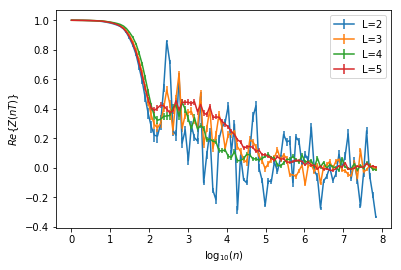

In [9]:
for i, row in enumerate(ReZ):
    plt.errorbar(np.log10(time_set), row, yerr=np.sqrt(varReZ[i]), label='L=%d' %sizes[i])
plt.ylabel(r'$Re\{Z(nT)\}$')
plt.xlabel(r'$\log_{10}(n)$')
plt.legend()
plt.show()

/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


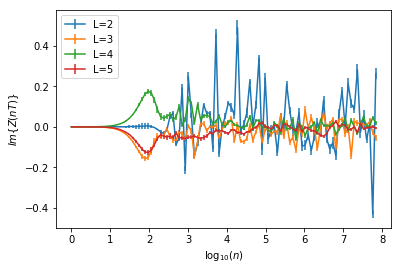

In [10]:
for i, row in enumerate(ImZ):
    plt.errorbar(np.log10(time_set), row, yerr=np.sqrt(varImZ[i]), label='L=%d' %sizes[i])
plt.ylabel(r'$Im \{Z(nT)\}$')
plt.xlabel(r'$\log_{10}(n)$')
plt.legend()
plt.show()

/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


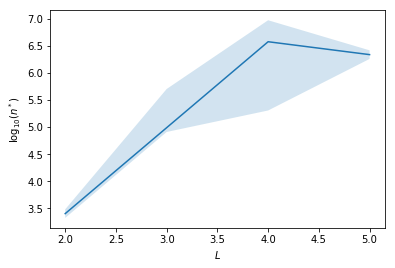

In [11]:
n_star = np.zeros(len(sizes), dtype=np.int32)
n_star_max = np.zeros(len(sizes), dtype=np.int32)
n_star_min = np.zeros(len(sizes), dtype=np.int32)
for i, row in enumerate(ReZ):
    n_star_max[i]=np.argmax(row+np.sqrt(varReZ[i])<0.)
    n_star_min[i]=np.argmax(row-np.sqrt(varReZ[i])<0.)
    n_star[i] = np.argmax(row<0.)
#errorbars = np.log10(time_set[n_star_max])-np.log10(time_set[n_star_min])/2
plt.plot(sizes, np.log10(time_set[n_star]))
plt.fill_between(sizes, np.log10(time_set[n_star_min-1]),np.log10(time_set[n_star_max+1]), alpha=0.2)
plt.xlabel(r'$L$')
plt.ylabel(r'$\log_{10}(n^*)$')
plt.show()

## Results

/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sqrt
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt
/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less


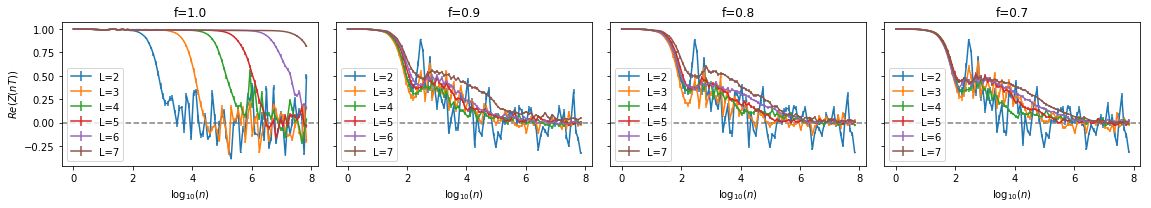

In [16]:
sizes=np.arange(2,8)
f_list=[1.0,0.9,0.8,0.7]

n_star = np.zeros((len(f_list), len(sizes)), dtype=np.int32)
n_star_max = np.zeros((len(f_list), len(sizes)), dtype=np.int32)
n_star_min = np.zeros((len(f_list), len(sizes)), dtype=np.int32)

fig, axes = plt.subplots(1, 4, sharey='all', figsize=(16,3))
for countf, f in enumerate(f_list):
    for countL, L in enumerate(sizes):
        time_set, ReZ, ImZ, varReZ, varImZ = np.loadtxt(\
            './Z3/Z3_L{}_f{}_h0.99_m1.0_J1.0_hz0.1_phiz0.0_hx0.0_phix0.0_ndis100.txt'.format(L,f),\
            unpack=True)
        axes[countf].errorbar(np.log10(time_set), ReZ, yerr=np.sqrt(varReZ), label='L={}'.format(L))
        n_star_max[countf,countL]=np.argmax(ReZ+np.sqrt(varReZ)<0.)
        n_star_min[countf,countL]=np.argmax(ReZ-np.sqrt(varReZ)<0.)
        n_star[countf,countL] = np.argmax(ReZ<0.)
    axes[countf].set_title('f={}'.format(f))
    axes[countf].set_xlabel(r'$\log_{10}(n)$')
    axes[countf].axhline(y=0, linestyle='dashed', color='gray')
    axes[countf].legend()
axes[0].set_ylabel(r'$Re(Z(nT))$')
plt.tight_layout()
plt.savefig('fig1.pdf')
plt.show()
    

/home/federica/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


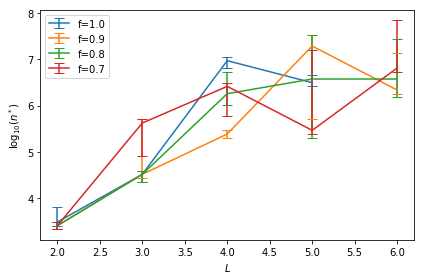

In [17]:
y = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star]))
y_max = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star_max+1]))
y_min = np.ma.masked_where(n_star_max <1, np.log10(time_set[n_star_min-1]))

for countf, f in enumerate(f_list):
    plt.errorbar(sizes, y[countf], yerr=[y[countf]-y_min[countf], y_max[countf]-y[countf]],\
                 label='f={}'.format(f),capsize=5)
plt.xlabel(r'$L$')
plt.ylabel(r'$\log_{10}(n^*)$')
plt.legend()
plt.tight_layout()
plt.savefig('fig2.pdf')
plt.show()